In [306]:
import numpy as np 
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
%matplotlib inline

# Data Load and Analysis
### Imagenette dataset is available on https://github.com/fastai/imagenette . 

 `print(imagenette_info)` gives following Information regarding the dataset:

*   `image.shape` -> (shape=(None, None, 3) we recognize that the images contained in the dataset have different sizes
*   By num_classes=10 we know that all images belong to 10 classes, or categories
*   total_num_examples=13394 indicates the number of images
*   Also, the images are already divided into "train" and "validation" and contain 9469 and 3925 images, respectively.


tfds.core.DatasetInfo(
    name='imagenette',
    version=0.1.0,
    description='Imagenette is a subset of 10 easily classified classes from the Imagenet
dataset. It was originally prepared by Jeremy Howard of FastAI. The objective
behind putting together a small version of the Imagenet dataset was mainly
because running new ideas/algorithms/experiments on the whole Imagenet take a
lot of time.

This version of the dataset allows researchers/practitioners to quickly try out
ideas and share with others. The dataset comes in three variants:

  * Full size
  * 320 px
  * 160 px

Note: The v2 config correspond to the new 70/30 train/valid split (released
in Dec 6 2019).',
    homepage='https://github.com/fastai/imagenette',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=13394,
    splits={
        'train': 9469,
        'validation': 3925,
    }

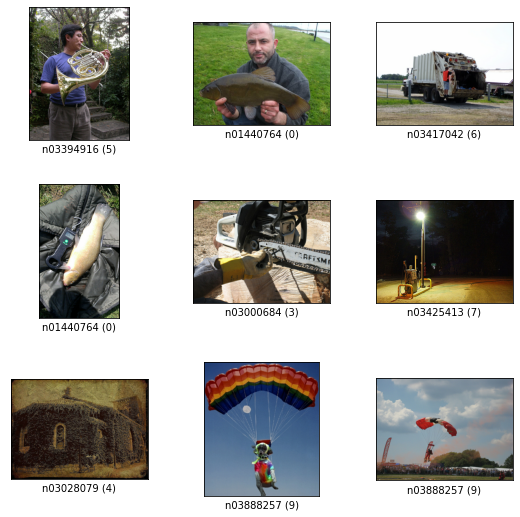

Test
3925


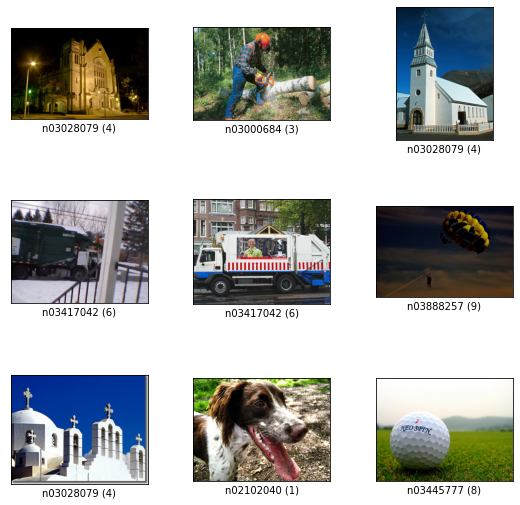

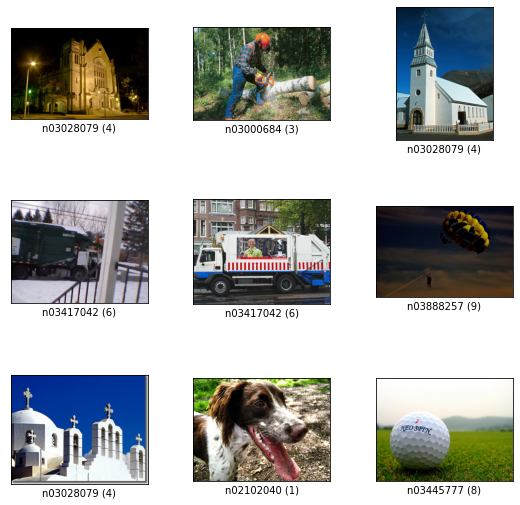

In [307]:
# reference :- https://www.tensorflow.org/datasets/overview
batch_size = 64
imagenette_builder = tfds.builder("imagenette/full-size-v2")
imagenette_info = imagenette_builder.info
print(imagenette_info)

imagenette_builder.download_and_prepare()
datasets = imagenette_builder.as_dataset(as_supervised=True)
(train_datasets,test_datasets)=imagenette_builder.as_dataset(split=['train', 'validation'],as_supervised=True, shuffle_files=True)
train_examples = imagenette_info.splits['train'].num_examples
validation_examples = imagenette_info.splits['validation'].num_examples


ds= train_datasets.take(4)  # Only take a few example
for image, label in ds:  # example is (image, label)
  print(image.shape, tfds.as_numpy(label))


print("Train")
print(train_examples)
tfds.show_examples(train_datasets, imagenette_builder.info)

print("Test")
print(validation_examples)
tfds.show_examples(test_datasets, imagenette_builder.info)


,image,label
0,,9 (n03888257)
1,,3 (n03000684)
2,,3 (n03000684)
3,,6 (n03417042)

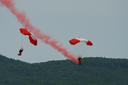
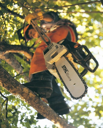
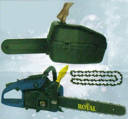
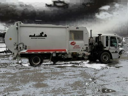

In [308]:
tfds.as_dataframe(train_datasets.take(4), imagenette_builder.info)

In [309]:
info = imagenette_builder.info
print(info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


Finally, there are 10 classes to which the images are assigned.  `print(info.features['label'].names)` goves this information.
Look into the images and determine the class label .

https://github.com/fastai/imagenette shows Imagenet classes are (tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute).

In [310]:
print(info.features["label"].num_classes)
print(info.features["label"].names)
print(info.features["label"].int2str(7))  # Human readable version (7 -> 'n03425413'->'gas pump')
print(info.features["label"].str2int('n03425413'))
class_labels = ['tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 
                  'garbage truck', 'gas pump', 'golf ball', 'parachute'] 

10
['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']
n03425413
7


In [311]:
print(info.features.shape)
print(info.features.dtype)
print(info.features['image'].shape)
print(info.features['image'].dtype)

{'image': (None, None, 3), 'label': ()}
{'image': tf.uint8, 'label': tf.int64}
(None, None, 3)
<dtype: 'uint8'>


In [312]:
print(info.splits)
print(list(info.splits.keys()))

{'train': <tfds.core.SplitInfo num_examples=9469>, 'validation': <tfds.core.SplitInfo num_examples=3925>}
['train', 'validation']


# Preprocessing steps

1.   Resize all the images (128,128, 3)
2.   Normalize pixel values of each image so that they are all in a   range between 0 and 1. Normally the value of a pixel is between 0 and 255 (RGB color values), but the neural networks prefer to calculate with values between 0 and 1, so we will simply divide each pixel value by 255.




In [313]:
size_image = 128
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(size_image, size_image,crop_to_aspect_ratio=True),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
]) 

In [314]:
train_datasets = train_datasets.map(
  lambda image,label: (resize_and_rescale(image, training=True),label)) 

In [315]:
test_datasets = test_datasets.map(
  lambda image, label: (resize_and_rescale(image, training=False), label)) 

In [316]:
for img, label in train_datasets.take(5):
  print(img.shape,label) 

(128, 128, 3) tf.Tensor(6, shape=(), dtype=int64)
(128, 128, 3) tf.Tensor(5, shape=(), dtype=int64)
(128, 128, 3) tf.Tensor(0, shape=(), dtype=int64)
(128, 128, 3) tf.Tensor(5, shape=(), dtype=int64)
(128, 128, 3) tf.Tensor(3, shape=(), dtype=int64)


In [317]:
def plot_images(data, size=(20,20)):
  plt.figure(figsize=size)
  for i in range(25):
    for img, label in data.take(i+1):
      plt.subplot(5, 5, i + 1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(True)
      plt.imshow(img, cmap=plt.cm.binary)
      plt.title(class_labels[label])
      plt.ylabel(img.shape)
  plt.show() 

In [318]:
plot_images(train_datasets) 

Output hidden; open in https://colab.research.google.com to view.

# Model

In [319]:
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),padding='same', activation=tf.keras.layers.ReLU(),input_shape=(128,128,3)),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),padding='same',activation=tf.keras.layers.ReLU()),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),padding='same',activation=tf.keras.layers.ReLU()),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),padding='same',activation=tf.keras.layers.ReLU()),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64,activation=tf.keras.layers.ReLU()),    
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10,activation='softmax')]) 

In [320]:
model.summary() 

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_145 (Conv2D)         (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_145 (MaxPooli  (None, 64, 64, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_146 (Conv2D)         (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_146 (MaxPooli  (None, 32, 32, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_147 (Conv2D)         (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_147 (MaxPooli  (None, 16, 16, 64)     

In [321]:
train_batch = train_datasets.batch(128)

test_batch = test_datasets.batch(128) 

In [322]:
for img, label in train_batch.take(5):
  print(img.shape,label) 

(128, 128, 128, 3) tf.Tensor(
[6 2 2 4 6 6 6 2 1 6 4 4 2 5 7 6 2 5 0 3 0 2 4 9 4 8 8 3 5 8 7 7 5 0 6 0 3
 7 4 9 9 4 7 9 8 6 3 9 2 6 7 3 4 5 3 3 3 4 4 3 2 7 4 5 9 7 3 5 4 7 1 0 7 0
 4 9 9 3 0 0 4 7 6 6 8 2 7 0 5 0 8 6 1 6 3 3 9 3 6 3 3 6 7 3 7 5 2 0 3 6 3
 0 0 3 2 8 2 0 1 0 1 1 3 8 3 2 7 1], shape=(128,), dtype=int64)
(128, 128, 128, 3) tf.Tensor(
[9 3 3 6 0 2 5 2 9 9 4 5 7 5 2 1 9 3 1 4 5 9 1 5 6 9 1 3 7 5 0 2 9 1 6 9 2
 5 4 4 6 8 0 0 1 6 7 6 6 5 0 5 3 8 9 0 9 1 9 7 2 7 7 2 2 6 4 0 8 1 2 7 4 0
 6 2 3 9 8 8 8 5 5 6 6 2 7 7 0 3 4 3 9 3 8 9 7 7 4 1 5 2 4 7 8 3 6 3 8 8 8
 5 4 9 0 2 4 7 5 0 3 8 3 0 6 4 8 5], shape=(128,), dtype=int64)
(128, 128, 128, 3) tf.Tensor(
[4 7 8 5 6 3 4 6 4 4 9 7 0 4 9 5 4 0 8 4 0 2 7 3 6 2 0 9 2 4 5 4 8 1 6 2 8
 6 9 1 5 8 0 8 1 6 9 7 2 8 0 0 1 8 4 4 3 6 9 8 4 8 0 8 0 3 2 6 6 8 1 6 0 3
 1 5 9 5 0 5 3 0 1 7 1 2 6 8 0 9 8 2 5 8 5 0 4 7 3 0 9 6 0 2 2 1 7 9 0 8 6
 2 5 8 7 4 2 7 0 2 3 2 5 5 0 1 2 6], shape=(128,), dtype=int64)
(128, 128, 128, 3) tf.Tensor(
[5 6 6 0 2 8 

In [323]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']) 


In [324]:
history = model.fit(train_batch,epochs=100,validation_data=test_batch,callbacks=[es]) 

Epoch 1/100
74/74 [==============================] - 17s 225ms/step - loss: 2.2141 - accuracy: 0.1932 - val_loss: 2.0777 - val_accuracy: 0.2805
Epoch 2/100
74/74 [==============================] - 17s 225ms/step - loss: 1.9995 - accuracy: 0.3010 - val_loss: 1.9001 - val_accuracy: 0.3710
Epoch 3/100
74/74 [==============================] - 16s 221ms/step - loss: 1.8535 - accuracy: 0.3617 - val_loss: 1.7708 - val_accuracy: 0.4257
Epoch 4/100
74/74 [==============================] - 17s 224ms/step - loss: 1.7422 - accuracy: 0.4097 - val_loss: 1.6967 - val_accuracy: 0.4344
Epoch 5/100
74/74 [==============================] - 17s 222ms/step - loss: 1.6690 - accuracy: 0.4359 - val_loss: 1.6493 - val_accuracy: 0.4568
Epoch 6/100
74/74 [==============================] - 17s 225ms/step - loss: 1.5931 - accuracy: 0.4641 - val_loss: 1.5561 - val_accuracy: 0.4836
Epoch 7/100
74/74 [==============================] - 17s 227ms/step - loss: 1.5344 - accuracy: 0.4804 - val_loss: 1.5176 - val_accuracy:

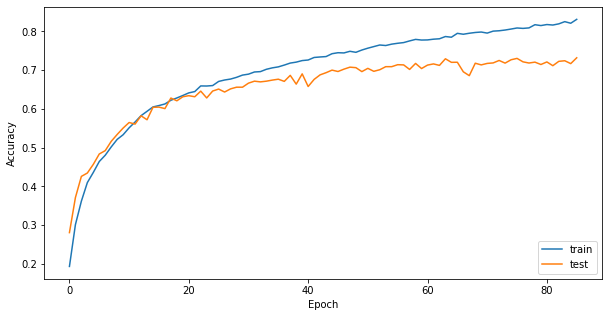

In [325]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right') 

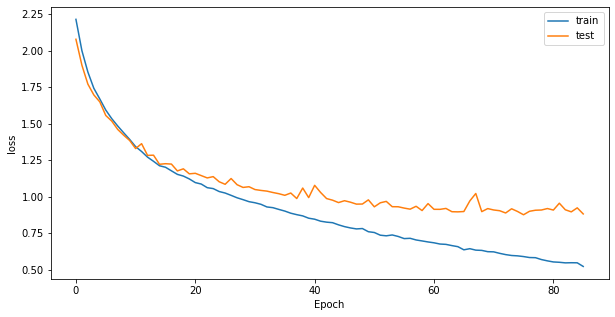

In [326]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label = 'test')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right') 

In [327]:
test_acc = model.evaluate(test_batch, verbose=2)
print('Test accuracy: ',test_acc[1]) 
print('Test loss: ',test_acc[0])


31/31 - 5s - loss: 0.8822 - accuracy: 0.7320 - 5s/epoch - 150ms/step
Test accuracy:  0.7319745421409607
Test loss:  0.8822094798088074


In [328]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [329]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img, cmap=plt.cm.binary)
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_labels[predicted_label],
                                100*np.max(predictions_array),
                                class_labels[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [330]:
labels =[]
labels_hat=[]
for image, label in test_batch:
  y_pred=model.predict(image)
  classes = np.argmax(y_pred,axis = 1)
  labels.extend(list(label.numpy()))
  labels_hat.extend(list(classes))

con_mat = tf.math.confusion_matrix(labels=labels, predictions=labels_hat).numpy()

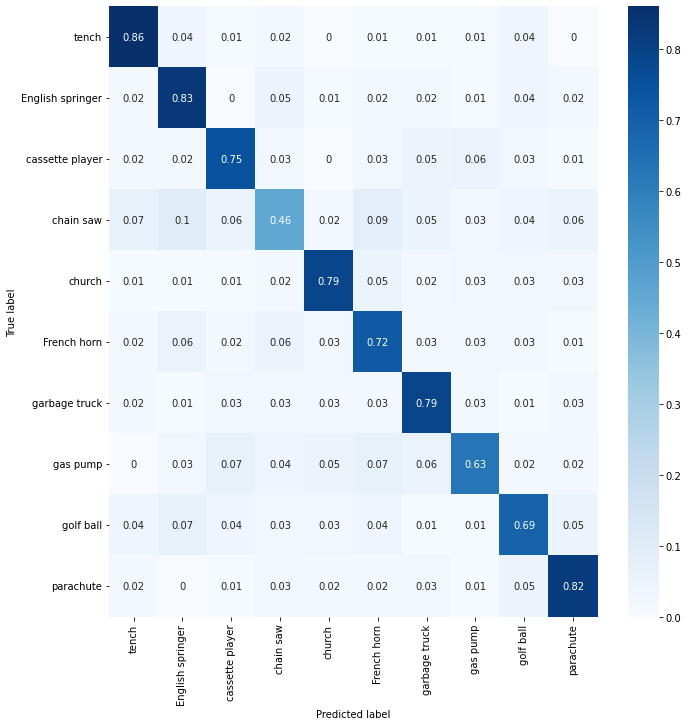

In [331]:
import pandas as pd
import seaborn as sns

con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = class_labels, 
                     columns = class_labels)

figure = plt.figure(figsize=(10, 10))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [332]:
#reference:- https://www.tensorflow.org/tutorials/keras/classification
for test_images, test_labels in test_batch.take(5):  
  for l in range(len(label)):
    predictions = probability_model.predict(test_images)
    i = l
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(1,2,2)
    plot_value_array(i, predictions[i],  test_labels)
    plt.show()
  

Output hidden; open in https://colab.research.google.com to view.